## Retrieving soot temperature from broadband emission measurements 
> ## U-Net,  $P_{\{R,G,B\}}$ $\rightarrow$ $T_s$

In [35]:
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import time, sys
from IPython.display import clear_output
import datetime
from tqdm.notebook import tqdm
import tensorflow.keras.backend as K
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 4]

########## CONFIG ##########
INPUT_1 = 'R'
INPUT_2 = 'G'
INPUT_3 = 'B'

OUTPUT = 'ts'

random.seed(19)
np.random.seed(19)
tf.random.set_seed(19)

TITLE = 'U-Net_B2040_syn_A'

ADD_NOISE = True
Dropout = None
percent_noise =  0.0025
COL = 40
############################
NPY_DIR2 = '/mnt/dataset-combustion/Simulations_coflame_yale/npy-PS44/'

RESULTS_DIR = './results/'
MODEL_FILE = './models/' +TITLE+ '/'+ TITLE +'.h5'

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    print("Folder created: ", RESULTS_DIR) 

if not os.path.exists('./models/' + TITLE):
    os.makedirs('./models/' + TITLE)
    print("Folder created: ", './models/' + TITLE) 
    
# Hyperparameters
num_filters = 29
val_dropout = 0.089735
learning_rate = 0.000410

def standarize(data, mean, std):
    return (data - mean) / std

def destandarize(data, mean, std):
    return (data * std) + mean

def mae_destandarize(y_true, y_pred):
    y_true_d = destandarize(y_true, y_mean, y_std)
    y_pred_d = destandarize(y_pred, y_mean, y_std)
    return K.mean(K.abs(y_pred_d - y_true_d))

def mae_percentage(y_true, y_pred):
    y_true_d = destandarize(y_true, y_mean, y_std)
    y_pred_d = destandarize(y_pred, y_mean, y_std)
    mae = K.mean(K.abs(y_pred_d - y_true_d))
    return (mae * 100) / y_mean

def predict(data):
    return destandarize(model.predict(standarize(data, x_mean, x_std)), y_mean, y_std)

def predict_single(data):
    data_map = standarize(data, x_mean, x_std)
    pred = model.predict(np.expand_dims(data_map, axis=0))[0]
    return destandarize(pred, y_mean, y_std)

def predict(data):
    assert data.ndim > 1
    data_s = standarize(data, x_mean, x_std)
    if data_s.ndim == 2:
        data_s = np.expand_dims(data_s, axis=0)
        pred = model.predict(data_s)[0]
    else:
        pred = model.predict(data_s)
    return destandarize(pred, y_mean, y_std)

def save_results(data, name):
    try:
        os.mkdir(RESULTS_DIR)
    except:
        pass
    try:
        os.mkdir(os.path.join(RESULTS_DIR, TITLE))
    except:
        pass
    dir_name = os.path.join(RESULTS_DIR, TITLE, name)
    try:
        os.mkdir(dir_name)
    except:
        pass
    for i in tqdm(range(data.shape[0]), total=data.shape[0], desc=name, unit=' files'):
        np.savetxt(os.path.join(dir_name, name + '_' + str(i) + '.dat'), data[i], delimiter='\n')

def add_noise(data, rng):
    assert np.size(NOISE_STDDEV) == 1 or np.size(NOISE_STDDEV) == 2
    if np.size(NOISE_STDDEV) == 1:
        data += rng.normal(0, NOISE_STDDEV, data.shape)
    else:
        s = rng.uniform(NOISE_STDDEV[0], NOISE_STDDEV[1], len(data))
        for i, d in enumerate(data):
            d += rng.normal(0, s[i], d.shape)
    return data

def format_to_train(x1,x2,x3):
    x1_t = np.transpose(x1, [0,3, 1, 2])
    x2_t = np.transpose(x2, [0,3, 1, 2])
    x3_t = np.transpose(x3, [0,3, 1, 2])
    xd = np.concatenate((x1_t,x2_t, x3_t), axis=1)
    xd = np.transpose(xd, [0,2, 3, 1])
    return xd

def max_mean(B1):
    B_max = list()
    for i in range(len(B1)):
        B_max.append(B1[i,:,:].max())
    B_max_mean = np.array(B_max).mean()
    B_max_std = np.array(B_max).std()

    print('max_mean: ',B_max_mean, 'Std: ',B_max_std, 'Min: ', np.array(B_max).min(), 'Max: ', np.array(B_max).max())
    return B_max_mean, B_max_std 


def plot_img(x_train, y_train, INPUT1, INPUT2, INPUT3, OUTPUT,  label):
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [18,4]
    plt.subplot(141)
    plt.imshow(x_train[:,:,0], cmap= 'jet')
    plt.title(INPUT1+'-'+str(label))
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(x_train[:,:,1], cmap= 'jet')
    plt.title(INPUT2+'-'+str(label))
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(x_train[:,:,2], cmap= 'jet')
    plt.title(INPUT3+'-'+str(label))
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(y_train, cmap= 'jet', vmin=y_train.max()*0.6, vmax=y_train.max())
    plt.title(OUTPUT+'-'+str(label))
    plt.colorbar()
    plt.show()
    
def destandarize_py(x_train):
    d1 = x_train[:,:,0]
    d1 = destandarize(d1, x1_mean,x1_std)
    d2 = x_train[:,:,1]
    d2 = destandarize(d2, x2_mean,x2_std)
    d3 = x_train[:,:,2]
    d3 = destandarize(d3, x3_mean,x3_std)
    d1 = d1.reshape(d1.shape[0],d1.shape[1], 1)
    d2 = d2.reshape(d2.shape[0],d2.shape[1], 1)
    d3 = d3.reshape(d3.shape[0],d3.shape[1], 1)

    d = np.concatenate((d1,d2,d3), axis =2)
    return d

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-08-22 14:11:42.762441: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-22 14:11:42.763080: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-22 14:11:42.818715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-22 14:11:42.818827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.645GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2023-08-22 14:11:42.818840: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-08-22 14:11:42.820091: I tensorflow/stream_executor/platfor

In [3]:
x1 = np.load(os.path.join(NPY_DIR2, INPUT_1 + '.npy'))[20:,:,:]
x2 = np.load(os.path.join(NPY_DIR2, INPUT_2 + '.npy'))[20:,:,:]
x3 = np.load(os.path.join(NPY_DIR2, INPUT_3 + '.npy'))[20:,:,:]
y = np.load(os.path.join(NPY_DIR2, OUTPUT + '.npy'))[20:,:,:]
fs = np.load(os.path.join(NPY_DIR2, 'fs.npy'))[20:,:,:]
r = np.load(os.path.join(NPY_DIR2, 'r.npy'))[20:,:]
z = np.load(os.path.join(NPY_DIR2, 'z.npy'))[20:,:]

x1 = x1[:,:88,:32]
x2 = x2[:,:88,:32]
x3 = x3[:,:88,:32]
y = y[:,:88,:32]
fs = fs[:,:88,:32]
r = r[:,:32]
z = z[:,:88]

for i in range(len(x2)):
    x_max = np.max([x1[i].max(),x2[i].max(),x3[i].max()])
    x2[i] = x2[i][::-1]/x_max
    x3[i] = x3[i][::-1]/x_max
    x1[i] = x1[i][::-1]/x_max
    y[i]= y[i][::-1]
    fs[i] = fs[i][::-1]
    z[i] = z[i][::-1]
    
x1_mean = np.mean(x1[:].mean())
x1_std = np.mean(x1[:].std())

x2_mean = np.mean(x2[:].mean())
x2_std = np.mean(x2[:].std())

x3_mean = np.mean(x3[:].mean())
x3_std = np.mean(x3[:].std())

y_mean = np.mean(y[:].mean())
y_std = np.mean(y[:].std())

x1_max_mean, _ = max_mean(x1)
x2_max_mean, _  = max_mean(x2)
x3_max_mean, _  = max_mean(x3)

#### NOISE
if ADD_NOISE:
    NOISE_STDDEV = [0, x3_max_mean*percent_noise]
    x1 = add_noise(x1, np.random.RandomState(0))
    x2 = add_noise(x2, np.random.RandomState(1))
    x3 = add_noise(x3, np.random.RandomState(2))
####

x1 = np.expand_dims(x1, axis=3)
x2 = np.expand_dims(x2, axis=3)
x3 = np.expand_dims(x3, axis=3)

x = format_to_train(x1,x2,x3)

print(x.shape)
print('Flame images:', x.shape[0])

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle=True)

x_train[:,:,:,0] = standarize(x_train[:,:,:,0], x1_mean, x1_std)
x_valid[:,:,:,0] = standarize(x_valid[:,:,:,0], x1_mean, x1_std)
x_train[:,:,:,1] = standarize(x_train[:,:,:,1], x2_mean, x2_std)
x_valid[:,:,:,1] = standarize(x_valid[:,:,:,1], x2_mean, x2_std)
x_train[:,:,:,2] = standarize(x_train[:,:,:,2], x3_mean, x3_std)
x_valid[:,:,:,2] = standarize(x_valid[:,:,:,2], x3_mean, x3_std)

y_train = standarize(y_train, y_mean, y_std)
y_valid = standarize(y_valid, y_mean, y_std)
del x1
del x2
del x3

max_mean:  0.2218462420770688 Std:  0.012764611403907186 Min:  0.18170888842641017 Max:  0.2619976347882157
max_mean:  1.0 Std:  0.0 Min:  1.0 Max:  1.0
max_mean:  0.8766132959834642 Std:  0.033716797112983574 Min:  0.7839980229171909 Max:  0.9976858748683779
(7979, 88, 32, 3)
Flame images: 7979


5411


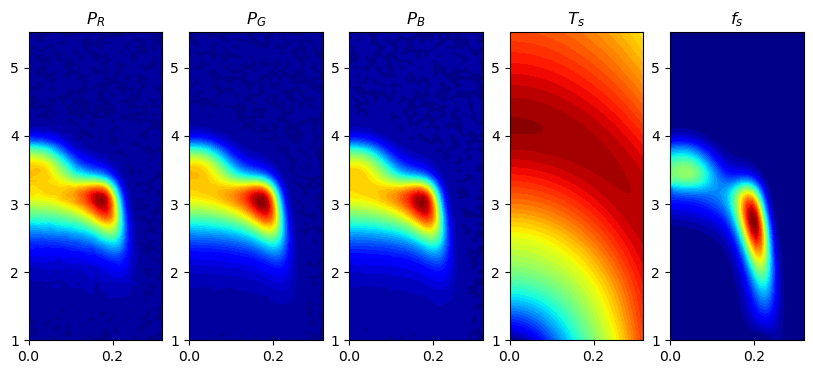

4708


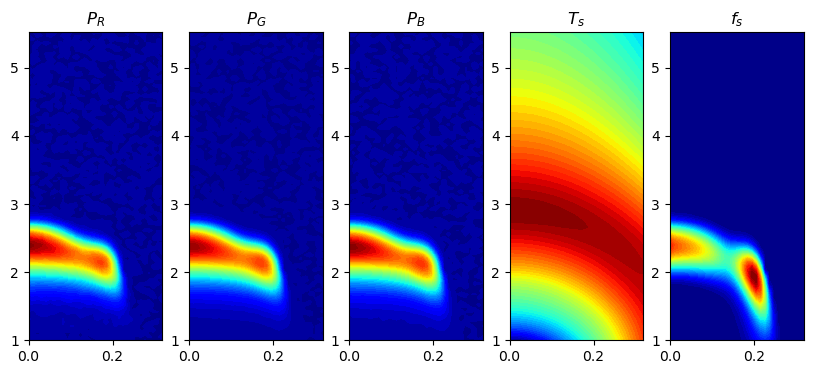

3488


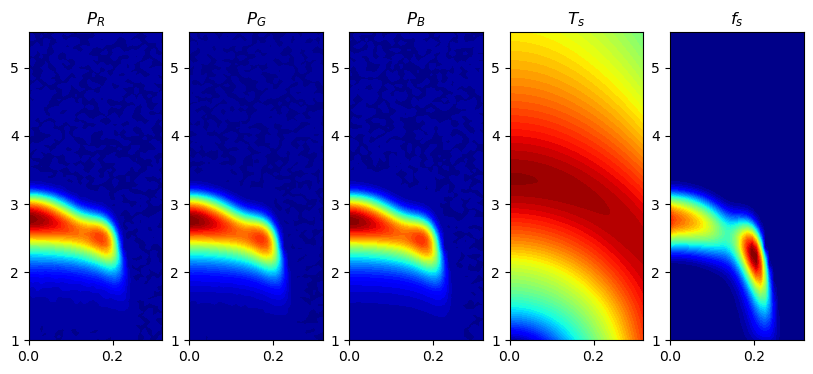

In [34]:
L = 50
for _ in range(3):
    plt.rcParams['figure.figsize'] = [10, 4]
    n = random.randint(0,len(x_train))
    print(n)
    plt.subplot(151)
    plt.contourf(r[n],z[n],x[n,:,:,0], cmap = 'jet', levels = L), plt.title('$P_{R}$')
    plt.subplot(152)
    plt.contourf(r[n],z[n],x[n,:,:,1], cmap = 'jet', levels = L), plt.title('$P_{G}$')
    plt.subplot(153)
    plt.contourf(r[n],z[n],x[n,:,:,2], cmap = 'jet', levels = L), plt.title('$P_{B}$')
    plt.subplot(154)
    plt.contourf(r[n],z[n],y[n], cmap = 'jet', levels = L), plt.title('$T_s$')
    plt.subplot(155)
    plt.contourf(r[n],z[n],fs[n]*1e6, cmap = 'jet', levels = L), plt.title('$f_{s}$')
    #plt.colorbar()
    plt.show()

# U-Net

In [5]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add, subtract
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [6]:
def conv_block(tensor, filters, kernel_size=3):
    c = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        activation = 'relu',
        kernel_initializer='he_normal',
        padding='same'
    )(tensor)
    c = BatchNormalization()(c)
    c = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        activation = 'relu',
        kernel_initializer='he_normal',
        padding='same'
    )(c)
    c = BatchNormalization()(c)
    return c

def deconv_block(tensor, filters, kernel_size=3):
    d = Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=(2,2),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same'
    )(tensor)
    d = BatchNormalization()(d)
    return d

    
def model_unet(input_img, depth=4, first_filters=8, kernel_size=3, dropout= None, skip_connection=False):
    # Contracting Path
    c = []
    for i in range(depth):
        if i == 0:
            c.append(conv_block(input_img, filters=(2**i)*first_filters))
        else:
            c.append(MaxPooling2D(pool_size=2)(c[i-1]))
            c[i] = conv_block(c[i], filters=(2**i)*first_filters)
        if dropout is not None:
            c[i] = Dropout(dropout)(c[i])
    # Expanding Path
    e = c[-1]
    for i in reversed(range(depth-1)):
        e = deconv_block(e, filters=(2**i)*first_filters)
        e = concatenate([e, c[i]])
        e = conv_block(e, filters=(2**i)*first_filters)
        if dropout is not None:
            c[i] = Dropout(dropout)(c[i])
        if i == 0:
            e = Conv2D(filters=1, kernel_size=1, activation='linear') (e)
    if skip_connection:
        e = add([input_img, e])
    model = Model(inputs=[input_img], outputs=[e])
    return model


inputs = Input(shape=(x_train.shape[1],x_train.shape[2],3))
model = model_unet(inputs, depth=4, first_filters=num_filters, dropout = val_dropout, skip_connection=False)

model.compile(
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    optimizer= Adam(lr = learning_rate),
    loss='mse',
    metrics=['mae', mae_destandarize, mae_percentage]
)

MODEL_FILE = './models/' + TITLE + '.h5'
es_cb = EarlyStopping(monitor='val_mae_percentage', mode='min', verbose=2, patience = 30)
cp_cb = ModelCheckpoint(MODEL_FILE, monitor='val_mae_percentage', verbose=1, save_best_only=False
                       , mode='auto', period=1)# mode='min')

history = model.fit(x = x_train, y = y_train,
        epochs = 100,
        #batch_size = 128,
        validation_data = (x_valid, y_valid),
        callbacks = [es_cb, cp_cb])

model = tf.keras.models.load_model(
    MODEL_FILE,
    custom_objects={'mae_destandarize': mae_destandarize, 'mae_percentage': mae_percentage}
)

2023-08-22 14:11:48.316611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 14:11:48.316953: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-22 14:11:48.317112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-22 14:11:48.317236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.645GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451

2023-08-22 14:11:49.228465: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-22 14:11:49.245416: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


Epoch 1/100


2023-08-22 14:11:50.643991: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-08-22 14:11:51.146073: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


200/200 [==============================] - 7s 26ms/step - loss: 0.4891 - mae: 0.4258 - mae_destandarize: 137.8014 - mae_percentage: 7.1377 - val_loss: 0.1492 - val_mae: 0.3083 - val_mae_destandarize: 99.7616 - val_mae_percentage: 5.1674

Epoch 00001: saving model to ./models/U-Net_B2040_syn_A.h5
Epoch 2/100
200/200 [==============================] - 4s 22ms/step - loss: 0.0227 - mae: 0.1126 - mae_destandarize: 36.4479 - mae_percentage: 1.8879 - val_loss: 0.0181 - val_mae: 0.1011 - val_mae_destandarize: 32.7271 - val_mae_percentage: 1.6952

Epoch 00002: saving model to ./models/U-Net_B2040_syn_A.h5
Epoch 3/100
200/200 [==============================] - 4s 22ms/step - loss: 0.0146 - mae: 0.0911 - mae_destandarize: 29.4904 - mae_percentage: 1.5275 - val_loss: 0.0131 - val_mae: 0.0840 - val_mae_destandarize: 27.1965 - val_mae_percentage: 1.4087

Epoch 00003: saving model to ./models/U-Net_B2040_syn_A.h5
Epoch 4/100
200/200 [==============================] - 4s 22ms/step - loss: 0.0116 - ma


Epoch 00027: saving model to ./models/U-Net_B2040_syn_A.h5
Epoch 28/100
200/200 [==============================] - 4s 21ms/step - loss: 0.0032 - mae: 0.0424 - mae_destandarize: 13.7180 - mae_percentage: 0.7106 - val_loss: 0.0027 - val_mae: 0.0351 - val_mae_destandarize: 11.3506 - val_mae_percentage: 0.5879

Epoch 00028: saving model to ./models/U-Net_B2040_syn_A.h5
Epoch 29/100
200/200 [==============================] - 4s 21ms/step - loss: 0.0037 - mae: 0.0464 - mae_destandarize: 15.0111 - mae_percentage: 0.7775 - val_loss: 0.0062 - val_mae: 0.0585 - val_mae_destandarize: 18.9178 - val_mae_percentage: 0.9799

Epoch 00029: saving model to ./models/U-Net_B2040_syn_A.h5
Epoch 30/100
200/200 [==============================] - 4s 21ms/step - loss: 0.0031 - mae: 0.0417 - mae_destandarize: 13.4866 - mae_percentage: 0.6986 - val_loss: 0.0030 - val_mae: 0.0404 - val_mae_destandarize: 13.0690 - val_mae_percentage: 0.6769

Epoch 00030: saving model to ./models/U-Net_B2040_syn_A.h5
Epoch 31/100


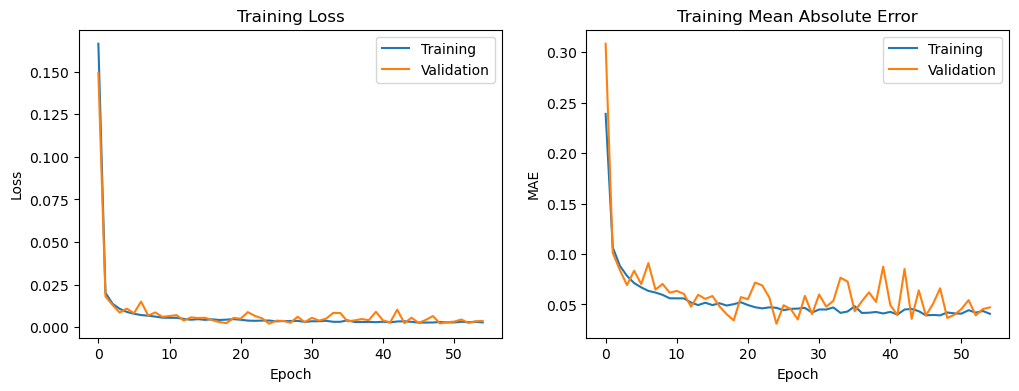

In [7]:
# Loss
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
# MAE
plt.subplot(122)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Training Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()

In [15]:
percent_noise =  0.0025
ADD_NOISE = True
x1_test = np.load(os.path.join(NPY_DIR2, INPUT_1 + '.npy'))[:20,:,:]
x2_test = np.load(os.path.join(NPY_DIR2, INPUT_2 + '.npy'))[:20,:,:]
x3_test =  np.load(os.path.join(NPY_DIR2, INPUT_3 + '.npy'))[:20,:,:]
y_test =  np.load(os.path.join(NPY_DIR2, OUTPUT + '.npy'))[:20,:,:]
fs_test = np.load(os.path.join(NPY_DIR2 +'fs.npy'))[:20,:,:]
r_test = np.load(os.path.join(NPY_DIR2, 'r.npy'))[:20,:]
z_test = np.load(os.path.join(NPY_DIR2, 'z.npy'))[:20,:]

for i in range(len(x2_test)):
    x_max = np.max([x1_test[i].max(),x2_test[i].max(),x3_test[i].max()])
    x1_test[i] = x1_test[i][::-1]/x_max
    x2_test[i] = x2_test[i][::-1]/x_max
    x3_test[i] = x3_test[i][::-1]/x_max
    y_test[i] = y_test[i][::-1]
    fs_test[i] = fs_test[i][::-1]
    z_test[i] = z_test[i][::-1]
    
x1_test = x1_test[:,128-88:,:32]
x2_test = x2_test[:,128-88:,:32]
x3_test = x3_test[:,128-88:,:32]
y_test = y_test[:,128-88:,:32]
fs_test = fs_test[:,128-88:,:32]
r_test = r_test[:,:32]
z_test = z_test[:,128-88:]

### NOISE
if ADD_NOISE:
    NOISE_STDDEV = x3_max_mean * percent_noise
    #NOISE_STDDEV = [0, x3_max_mean*percent_noise]
    x1_test = add_noise(x1_test, np.random.RandomState(0))
    x2_test = add_noise(x2_test, np.random.RandomState(1))
    x3_test = add_noise(x3_test, np.random.RandomState(2))
###
x1_test[x1_test<0] = 0
x2_test[x2_test<0] = 0
x3_test[x3_test<0] = 0 
    
x1_test = np.expand_dims(x1_test, axis=3)
x2_test = np.expand_dims(x2_test, axis=3)
x3_test = np.expand_dims(x3_test, axis=3)

x_test = format_to_train(x1_test,x2_test,x3_test)

x_test[:,:,:,0] = standarize(x_test[:,:,:,0], x1_mean, x1_std)
x_test[:,:,:,1] = standarize(x_test[:,:,:,1], x2_mean, x2_std)
x_test[:,:,:,2] = standarize(x_test[:,:,:,2], x3_mean, x3_std)

####LOAD######
model = tf.keras.models.load_model(
    MODEL_FILE,
    custom_objects={'mae_destandarize': mae_destandarize, 'mae_percentage': mae_percentage}
)
y_test_pred = model.predict(x_test)
y_test_pred = destandarize(y_test_pred, y_mean, y_std)

#model.evaluate(x_test, standarize(y_test, y_mean, y_std))

x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],x_test.shape[3])
y_test_pred = y_test_pred.reshape(y_test_pred.shape[0],y_test_pred.shape[1],y_test_pred.shape[2])


11
Abs. error max: 20.650622749578133
Abs. error min: 0.0
Abs. error mean: 1.7498617824209484
Abs. error stddev: 3.339376267172258
Abs. error %: 0.29408674743042174


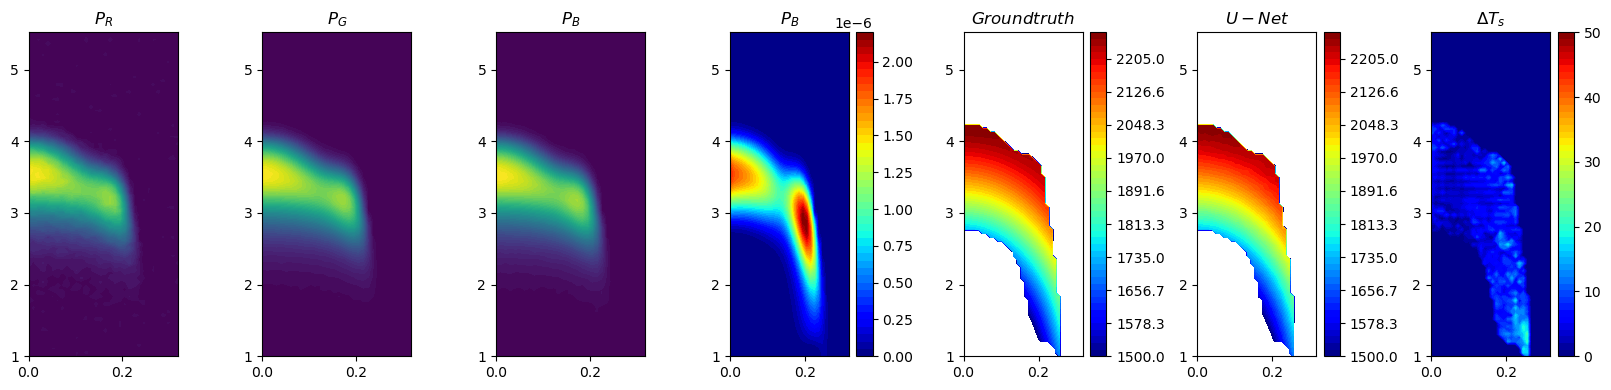

In [31]:
from matplotlib.ticker import MaxNLocator
N = random.randint(0,len(x_test)-1)
y_test[N][fs_test[N] <= 0.05e-6] = 0
y_test_pred[N][fs_test[N] <= 0.05e-6] = 0
print(N)
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 4]
L = np.linspace(x_test[N,:,:,:].min(),x_test[N,:,:,:].max(),50)
plt.subplot(171)
plt.contourf(r_test[N],z_test[N],x_test[N,:,:,0],levels = L, cmap = 'viridis')
plt.title('$P_{R}$')
#plt.colorbar()
plt.subplot(172)
plt.contourf(r_test[N],z_test[N],x_test[N,:,:,1],levels = L, cmap = 'viridis')
plt.title('$P_{G}$')
#plt.colorbar()
plt.subplot(173)
plt.contourf(r_test[N],z_test[N],x_test[N,:,:,2],levels = L, cmap = 'viridis')
plt.title('$P_{B}$')
#plt.colorbar()
L = 50
plt.subplot(174)
plt.contourf(r_test[N],z_test[N],fs_test[N,:,:],levels = L, cmap = 'jet')
plt.title('$P_{B}$')
plt.colorbar()

L = np.linspace(1500,y_test[N,:,:].max(),50)
plt.subplot(175)
plt.contourf(r_test[N],z_test[N],y_test[N,:,:],levels = L, cmap = 'jet')
plt.title('$Groundtruth$')
plt.colorbar()
plt.subplot(176)
plt.contourf(r_test[N],z_test[N],y_test_pred[N],levels = L, cmap = 'jet')
plt.title('$U-Net$')
plt.colorbar()
plt.tight_layout()

abs_err = np.abs(y_test[N] - y_test_pred[N])
L = np.linspace(0,50,50)
plt.subplot(177)
plt.contourf(r_test[N],z_test[N],abs_err,levels = L, cmap = 'jet')
plt.title('$\Delta T_{s}$')
plt.colorbar(ticks=MaxNLocator(6))
print('Abs. error max:', abs_err.max())
print('Abs. error min:', abs_err.min())
print('Abs. error mean:', abs_err.mean())
print('Abs. error stddev:', abs_err.std())
print('Abs. error %:', abs_err.mean()*100/y_test[N].mean())